In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
import warnings
from IPython.display import display
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE, ADASYN

# import sklearn.preprocessing
# from scipy import stats
# from scipy.stats import t

# from sklearn.metrics import roc_curve
# from sklearn.metrics import auc
from sklearn.feature_selection import SelectFromModel
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_predict
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import StratifiedShuffleSplit
# from sklearn.ensemble import BaggingClassifier
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn import naive_bayes
# from sklearn import neighbors

%matplotlib inline

In [2]:
# Loading the data set and splitting off the target feature, 'Class'
image_df = pd.read_table("uspsdata.txt", header=None)
class_df = pd.read_table("uspscl.txt", header=None)
display(image_df.head(5))
display(class_df.head(5))

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.0,0.0,0.00,0.00,0.95,11.91,49.02,106.96,152.14,157.77,...,145.84,154.03,152.60,142.38,125.40,100.57,69.80,38.67,14.58,2.80
1,0.0,0.0,3.31,19.03,51.45,87.66,106.14,102.35,96.37,106.66,...,125.28,141.59,145.34,135.52,110.81,74.17,36.65,11.53,1.81,0.07
2,0.0,0.0,0.02,1.86,12.63,42.03,84.17,104.87,79.06,32.90,...,158.29,150.08,134.27,113.54,85.57,52.14,23.76,7.75,1.76,0.23
3,0.0,0.0,0.00,0.01,5.93,33.21,75.00,85.97,51.36,14.25,...,157.26,156.53,139.58,104.68,63.12,28.38,8.15,1.11,0.02,0.00
4,0.0,0.0,0.94,8.57,32.06,63.96,74.10,50.12,18.39,2.83,...,93.12,87.66,59.11,26.47,8.72,2.48,0.42,0.00,0.00,0.00


,0
0,-1
1,-1
2,1
3,1
4,1


In [3]:
scaler = StandardScaler()
scaled_image_df = scaler.fit_transform(image_df)

In [4]:
img_train, img_test, class_train, class_test = train_test_split(scaled_image_df,
                                                                class_df,
                                                                test_size=0.20,
                                                                random_state=123)

In [5]:
# switch to LinearSVC when making SVCs with datasets > 10k rows
# svm_clf = LinearSVC(C=1, loss="hinge")  
svm_clf = SVC(kernel='linear')

In [8]:
parameters = {
    'C': [1e-05, 2e-05, 5e-05, 6e-05, 7e-05, 8e-05, 9e-05, 
          1e-04, 2e-04, 3e-04, 4e-04, 5e-04, 
          1e-03, 2e-03, 5e-03, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 5],
    'random_state': [123]
}

In [10]:
svm_clf_grid = GridSearchCV(svm_clf, parameters, verbose=1, cv=30, n_jobs=-1)

# As the GridSearchCV function inherently 
%time svm_clf_grid.fit(scaled_image_df, np.ravel(class_df))

Fitting 30 folds for each of 23 candidates, totalling 690 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s


Wall time: 4.76 s


[Parallel(n_jobs=-1)]: Done 690 out of 690 | elapsed:    4.2s finished


GridSearchCV(cv=30, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'random_state': [123], 'C': [1e-05, 2e-05, 5e-05, 6e-05, 7e-05, 8e-05, 9e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [11]:
def print_clf_grid_stats(grid_clf, gamma=False):
    print('C value that produces the most accurate model: {}'.format(grid_clf.best_params_))
    print('Score of the most accurate model: {:.6f} \n'.format(grid_clf.best_score_))
    means = grid_clf.cv_results_['mean_test_score']
    stdevs = grid_clf.cv_results_['std_test_score']
    c_list_ = []
    g_list_ = []
    print('   --- Mean accuracy (+/- standard deviation) for different C values ---')
    for mean, stdev, param in zip(means, stdevs, grid_clf.cv_results_['params']):
        c_list_.append(param['C'])
        if gamma:
            g_list_.append(param['gamma'])
        print('{:0.3f} (+/- {:0.3f}) for the model with parameters {}'.format(mean, stdev, param))
    return means, stdevs, c_list_, g_list_

score_means, score_stdevs, c_list, _ = print_clf_grid_stats(svm_clf_grid)

C value that produces the most accurate model: {'random_state': 123, 'C': 0.001}
Score of the most accurate model: 0.970000 

   --- Mean accuracy (+/- standard deviation) for different C values ---
0.835 (+/- 0.136) for the model with parameters {'random_state': 123, 'C': 1e-05}
0.835 (+/- 0.136) for the model with parameters {'random_state': 123, 'C': 2e-05}
0.835 (+/- 0.136) for the model with parameters {'random_state': 123, 'C': 5e-05}
0.835 (+/- 0.136) for the model with parameters {'random_state': 123, 'C': 6e-05}
0.835 (+/- 0.136) for the model with parameters {'random_state': 123, 'C': 7e-05}
0.880 (+/- 0.113) for the model with parameters {'random_state': 123, 'C': 8e-05}
0.915 (+/- 0.086) for the model with parameters {'random_state': 123, 'C': 9e-05}
0.915 (+/- 0.086) for the model with parameters {'random_state': 123, 'C': 0.0001}
0.950 (+/- 0.069) for the model with parameters {'random_state': 123, 'C': 0.0002}
0.965 (+/- 0.061) for the model with parameters {'random_stat

In [12]:
# Apparently Seaborn's tsplot will be deprecated, so I made just made a similar
#  plot using matplotlib (Seaborn is just a nice wrapper for matplotlib anyway)
def errorbar_lineplot(ax, x, y, stdev, **kw):
    c_intervals = (y - stdev, y + stdev)
    ax.fill_between(x, c_intervals[0], c_intervals[1], alpha=0.2, **kw)
    ax.plot(x, y, **kw)

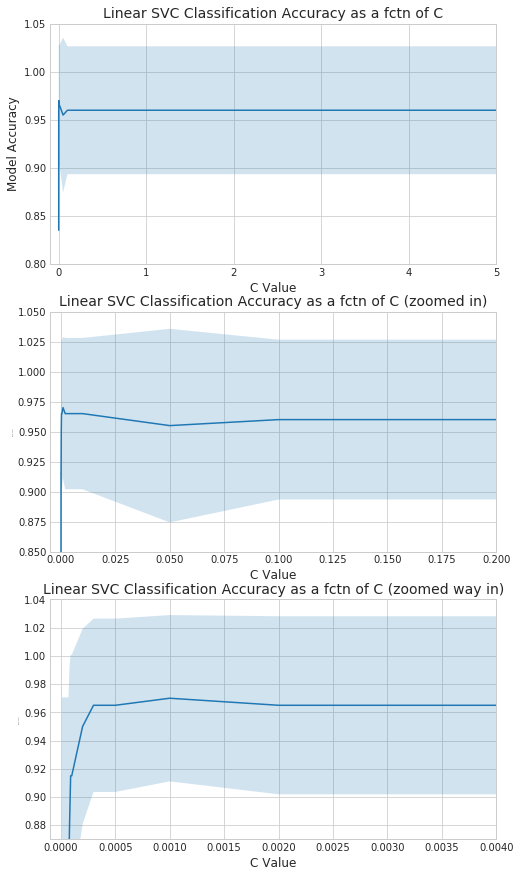

In [13]:
with plt.style.context('seaborn-whitegrid'):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=False, figsize=(8,15))
    errorbar_lineplot(ax1, c_list, score_means, score_stdevs)
    ax1.set_xlabel('C Value', fontsize=12)
    ax1.set_ylabel('Model Accuracy', fontsize=12)
    ax1.set_ylim([0.8,1.05])
    ax1.set_xlim([-0.1,5.0])
    ax1.set_title('Linear SVC Classification Accuracy as a fctn of C', fontsize=14)
    errorbar_lineplot(ax2, c_list, score_means, score_stdevs)
    ax2.set_xlabel('C Value', fontsize=12)
    ax2.set_ylabel('Model Accuracy', fontsize=1)
    ax2.set_ylim([0.85,1.05])
    ax2.set_xlim([-0.005,0.2])
    ax2.set_title('Linear SVC Classification Accuracy as a fctn of C (zoomed in)', fontsize=14)
    errorbar_lineplot(ax3, c_list, score_means, score_stdevs)
    ax3.set_xlabel('C Value', fontsize=12)
    ax3.set_ylabel('Model Accuracy', fontsize=1)
    ax3.set_ylim([0.87,1.04])
    ax3.set_xlim([-0.0001,0.004])
    ax3.set_title('Linear SVC Classification Accuracy as a fctn of C (zoomed way in)', fontsize=14)

Looking at the printout of accuracy values and the plots of classifier accuracy as a function of C value, we see that model accuracy rises as C increases from $C = 0.00001$ to a peak accuracy at $C=0.001$ then a shallow dip and then model accuracy converges to a constant hyperplane (or at least a hyperplane that doesn't cross over any additional datapoints) for all values of $C >= 0.100$. This kind contradicts my intuition, as higher values of $C$ indicate a greater aversion to misclassification (ie inaccuracy). I should test this with more random_state seed numbers.

In [14]:
# This function calculates the total accuracy of a classifiers, clf 
#  on the same training and testing data, as well as the accuracy on the training
#  data (which gives the resubstitution (resub) error) and accuracy on the testing
#  data (which gives the generalization error).
# Takes 2 classifiers that conform to the sklearn classifier interface, strings
#  containing the names of the classifiers
# data_df:  an array-like object containing 
def svm_c_explorer(clf, clf_name, data_df, class_df,\
                   test_size=0.34, printStats=True, n_trials=30, seed=1234):
    rng = np.random.RandomState(seed)
    random_seeds = rng.randint(low=0, high=99999, size=n_trials)
    clf_acc = [] #; clf_resub_acc = []; clf_gen_acc = []
    for i in range(n_trials):
        data_train_, data_test_, class_train_, class_test_ = \
                train_test_split(data_df, class_df, test_size=test_size, \
                                 random_state=random_seeds[i])
        clf_acc.append(clf_evaluation(clf, data_train_, data_test_, class_train_, class_test_))
#     clf_resub, clf_gen = resub_and_gen_errors(clf, data_train_, data_test_, class_train_, class_test_)
#     clf_resub_acc.append(clf_resub)
#     clf_gen_acc.append(clf_gen)
    mean_var_CI_calculator(clf_name, pd.Series(clf_acc), test_size, printStats)
    return clf_acc #, clf_resub_acc, clf_gen_acc

# This executes a simple fit-predict-evaluate routine with a single data split.
# classifier:   a classifier model that conforms to sklearns regular classifier interface
# data/class_train/test: array-like containers holding corresponding data and class labels
def clf_evaluation(clf_, data_train_, data_test_, class_train_, class_test_):
    clf_fit = clf_.fit(data_train_, class_train_)
    clf_pred = clf_.predict(data_test_)
    return accuracy_score(class_test_, clf_pred)

def resub_and_gen_errors(clf_, data_train_, data_test_, class_train_, class_test_):
    clf_.fit(data_train_, class_train_)
    resub_err = clf_.score(data_train_, class_train_)
    gen_err = clf_.score(data_test_, class_test_)
    return resub_err, gen_err

In [15]:
svm_clf = SVC(kernel='linear')
params2 = {
    'kernel': ['linear'],
    'C': [1e-05, 2e-05, 5e-05, 6e-05, 7e-05, 8e-05, 9e-05, 
          1e-04, 2e-04, 3e-04, 4e-04, 5e-04, 
          1e-03, 2e-03, 5e-03, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 5]
}

In [16]:
svm_clf_grid2 = GridSearchCV(svm_clf, params2, verbose=1, cv=30, n_jobs=-1)

# As the GridSearchCV function inherently 
%time svm_clf_grid2.fit(scaled_image_df, np.ravel(class_df))

Fitting 30 folds for each of 23 candidates, totalling 690 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s


Wall time: 4.66 s


[Parallel(n_jobs=-1)]: Done 690 out of 690 | elapsed:    4.1s finished


GridSearchCV(cv=30, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'kernel': ['linear'], 'C': [1e-05, 2e-05, 5e-05, 6e-05, 7e-05, 8e-05, 9e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [17]:
score_means, score_stdevs, c_list, _ = print_clf_grid_stats(svm_clf_grid2)

C value that produces the most accurate model: {'kernel': 'linear', 'C': 0.001}
Score of the most accurate model: 0.970000 

   --- Mean accuracy (+/- standard deviation) for different C values ---
0.835 (+/- 0.136) for the model with parameters {'kernel': 'linear', 'C': 1e-05}
0.835 (+/- 0.136) for the model with parameters {'kernel': 'linear', 'C': 2e-05}
0.835 (+/- 0.136) for the model with parameters {'kernel': 'linear', 'C': 5e-05}
0.835 (+/- 0.136) for the model with parameters {'kernel': 'linear', 'C': 6e-05}
0.835 (+/- 0.136) for the model with parameters {'kernel': 'linear', 'C': 7e-05}
0.880 (+/- 0.113) for the model with parameters {'kernel': 'linear', 'C': 8e-05}
0.915 (+/- 0.086) for the model with parameters {'kernel': 'linear', 'C': 9e-05}
0.915 (+/- 0.086) for the model with parameters {'kernel': 'linear', 'C': 0.0001}
0.950 (+/- 0.069) for the model with parameters {'kernel': 'linear', 'C': 0.0002}
0.965 (+/- 0.061) for the model with parameters {'kernel': 'linear', 'C

In [18]:
svm_clf = SVC()
params_gauss = {
    'kernel': ['rbf'],
    'gamma': [1e-03, 5e-03, 0.001, 0.002, 0.003, 0.004, 0.005, 0.007, 0.01, 0.1, 1],
    'C': [1e-05, 7e-05, 1e-04, 5e-04, 9e-04, 
          1e-03, 2e-03, 5e-03, 0.01, 0.05, 0.1, 
          0.125, 0.15, 0.175, 0.2, 0.25, 0.5, 1, 2, 5]    
}

In [19]:
svm_gauss_clf_grid = GridSearchCV(svm_clf, params_gauss, verbose=1, cv=30, n_jobs=-1)

%time svm_gauss_clf_grid.fit(scaled_image_df, np.ravel(class_df))

Fitting 30 folds for each of 220 candidates, totalling 6600 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 800 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 2300 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 4400 tasks      | elapsed:   21.0s


Wall time: 28.3 s


[Parallel(n_jobs=-1)]: Done 6600 out of 6600 | elapsed:   27.7s finished


GridSearchCV(cv=30, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'gamma': [0.001, 0.005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.007, 0.01, 0.1, 1], 'kernel': ['rbf'], 'C': [1e-05, 7e-05, 0.0001, 0.0005, 0.0009, 0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25, 0.5, 1, 2, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [20]:
score_means, score_stdevs, c_list, g_list = print_clf_grid_stats(svm_gauss_clf_grid, True)

C value that produces the most accurate model: {'gamma': 0.003, 'kernel': 'rbf', 'C': 0.15}
Score of the most accurate model: 0.985000 

   --- Mean accuracy (+/- standard deviation) for different C values ---
0.935 (+/- 0.073) for the model with parameters {'gamma': 0.001, 'kernel': 'rbf', 'C': 1e-05}
0.910 (+/- 0.087) for the model with parameters {'gamma': 0.005, 'kernel': 'rbf', 'C': 1e-05}
0.935 (+/- 0.073) for the model with parameters {'gamma': 0.001, 'kernel': 'rbf', 'C': 1e-05}
0.955 (+/- 0.067) for the model with parameters {'gamma': 0.002, 'kernel': 'rbf', 'C': 1e-05}
0.940 (+/- 0.080) for the model with parameters {'gamma': 0.003, 'kernel': 'rbf', 'C': 1e-05}
0.920 (+/- 0.081) for the model with parameters {'gamma': 0.004, 'kernel': 'rbf', 'C': 1e-05}
0.910 (+/- 0.087) for the model with parameters {'gamma': 0.005, 'kernel': 'rbf', 'C': 1e-05}
0.875 (+/- 0.112) for the model with parameters {'gamma': 0.007, 'kernel': 'rbf', 'C': 1e-05}
0.835 (+/- 0.142) for the model with p

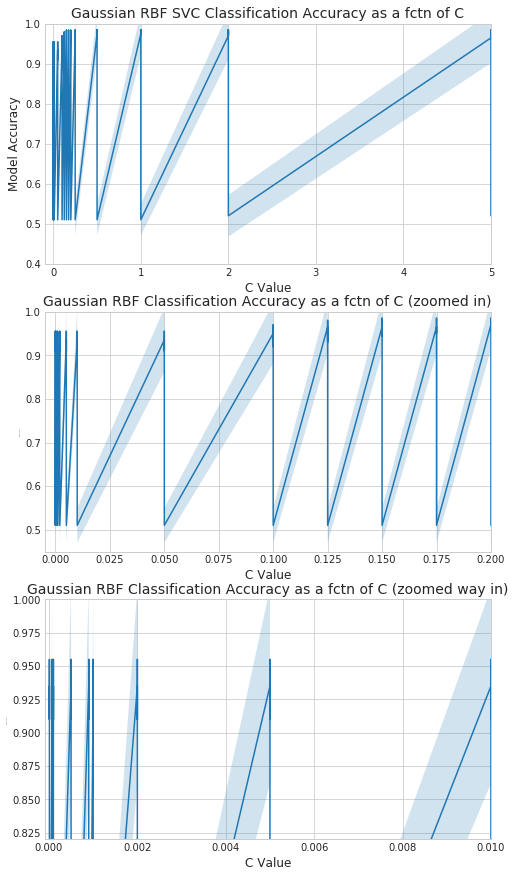

In [21]:
with plt.style.context('seaborn-whitegrid'):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=False, figsize=(8,15))
    errorbar_lineplot(ax1, c_list, score_means, score_stdevs)
    ax1.set_xlabel('C Value', fontsize=12)
    ax1.set_ylabel('Model Accuracy', fontsize=12)
    ax1.set_ylim([0.4,1.0])
    ax1.set_xlim([-0.1,5.0])
    ax1.set_title('Gaussian RBF SVC Classification Accuracy as a fctn of C', fontsize=14)
    errorbar_lineplot(ax2, c_list, score_means, score_stdevs)
    ax2.set_xlabel('C Value', fontsize=12)
    ax2.set_ylabel('Model Accuracy', fontsize=1)
    ax2.set_ylim([0.45,1.00])
    ax2.set_xlim([-0.005,0.2])
    ax2.set_title('Gaussian RBF Classification Accuracy as a fctn of C (zoomed in)', fontsize=14)
    errorbar_lineplot(ax3, c_list, score_means, score_stdevs)
    ax3.set_xlabel('C Value', fontsize=12)
    ax3.set_ylabel('Model Accuracy', fontsize=1)
    ax3.set_ylim([0.82,1.00])
    ax3.set_xlim([-0.0001,0.01])
    ax3.set_title('Gaussian RBF Classification Accuracy as a fctn of C (zoomed way in)', fontsize=14)

In [22]:
gauss_data = {'mean_acc': score_means,
              'mean_std': score_stdevs,
              'gamma':g_list,
              'C':c_list}
gauss_df = pd.DataFrame(gauss_data)
gauss_df = gauss_df.sort_values('gamma')
gauss_df_bestC = gauss_df[gauss_df['C']==0.15]
gauss_df_bestC

,C,gamma,mean_acc,mean_std
132,0.15,0.001,0.965,0.061441
134,0.15,0.001,0.965,0.061441
135,0.15,0.002,0.980,0.050166
136,0.15,0.003,0.985,0.043108
137,0.15,0.004,0.965,0.061441
133,0.15,0.005,0.945,0.069940
138,0.15,0.005,0.945,0.069940
139,0.15,0.007,0.910,0.095873
140,0.15,0.010,0.875,0.119024
141,0.15,0.100,0.545,0.071122


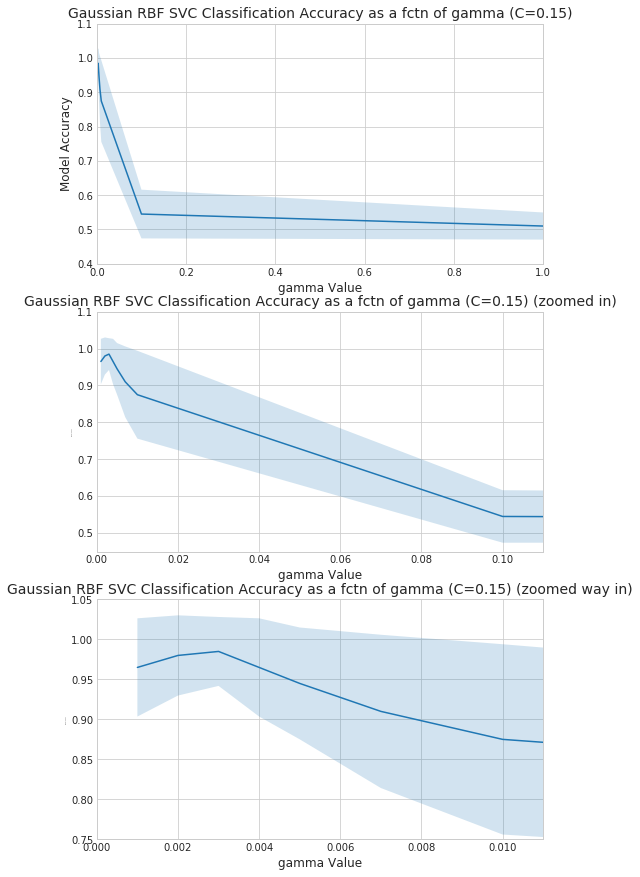

In [23]:
title = 'Gaussian RBF SVC Classification Accuracy as a fctn of gamma (C=0.15)'
xlab = 'gamma Value'
this_df = gauss_df[gauss_df['C']==0.15]  # C=0.15 produced the most accurate model
with plt.style.context('seaborn-whitegrid'):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=False, figsize=(8,15))
    errorbar_lineplot(ax1, this_df['gamma'], this_df['mean_acc'], this_df['mean_std'])
    ax1.set_xlabel(xlab, fontsize=12)
    ax1.set_ylabel('Model Accuracy', fontsize=12)
    ax1.set_ylim([0.4,1.1])
    ax1.set_xlim([0.0,1.0])
    ax1.set_title(title, fontsize=14)
    errorbar_lineplot(ax2, this_df['gamma'], this_df['mean_acc'], this_df['mean_std'])
    ax2.set_xlabel(xlab, fontsize=12)
    ax2.set_ylabel('Model Accuracy', fontsize=1)
    ax2.set_ylim([0.45,1.1])
    ax2.set_xlim([0.0,0.11])
    ax2.set_title(title + ' (zoomed in)', fontsize=14)
    errorbar_lineplot(ax3, this_df['gamma'], this_df['mean_acc'], this_df['mean_std'])
    ax3.set_xlabel(xlab, fontsize=12)
    ax3.set_ylabel('Model Accuracy', fontsize=1)
    ax3.set_ylim([0.75,1.05])
    ax3.set_xlim([0.0,0.011])
    ax3.set_title(title + ' (zoomed way in)', fontsize=14)

## 2: E-Commerce Customer Identification

In [24]:
train10k_raw = pd.read_csv('train10000.csv', header=None, na_values='999000.0')
train10k_labels = pd.read_csv('train10000_label.csv', header=None, na_values='999000.0')
test10k_raw = pd.read_csv('test10000.csv', header=None, na_values='998880.0')
test10k_labels = pd.read_csv('test10000_label.csv', header=None, na_values='999000.0')

# fixing column names
col_nums = np.arange(train10k_raw.shape[1])
X_gon_giveit2ya = np.vectorize(lambda x: 'x' + str(x))
train10k_raw.columns = X_gon_giveit2ya(col_nums)
train10k_labels.columns = ['Y']
test10k_raw.columns = X_gon_giveit2ya(col_nums)
test10k_labels.columns = ['Y']

In [25]:
print('Training Data')
display(train10k_raw.head(5))
print('Training Data DataFrame size = {}'.format(train10k_raw.shape))
print('***********************************************\n\nTesting Data')
display(test10k_raw.head(5))
print('Testing Data DataFrame size = {}'.format(test10k_raw.shape))
print('***********************************************\n\nTraining Labels')
display(train10k_labels.head(5))
print('Testing Labels')
display(test10k_labels.head(5))

Training Data


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x324,x325,x326,x327,x328,x329,x330,x331,x332,x333
0,NaN,46,2.0,46,196000.0,2.0,NaN,4.0,3.0,NaN,...,59,19,99,21,6,8,11,27,254,110
1,1.0,50,1.0,50,196000.0,1.0,4.0,7.0,5.0,1.0,...,51,24,89,13,11,2,10,30,169,144
2,NaN,50,1.0,50,196000.0,1.0,4.0,NaN,7.0,NaN,...,61,20,98,17,7,2,10,24,337,105
3,1.0,58,1.0,58,195000.0,2.0,4.0,NaN,8.0,2.0,...,50,19,83,12,8,4,4,31,280,165
4,NaN,64,1.0,64,196000.0,1.0,4.0,2.0,2.0,NaN,...,57,23,99,22,4,8,44,27,143,12


Training Data DataFrame size = (10000, 334)
***********************************************

Testing Data


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x324,x325,x326,x327,x328,x329,x330,x331,x332,x333
0,1.0,36,3.0,36,197200.0,1.0,NaN,NaN,7.0,2.0,...,63,9,97,24,3,4,7,14,347,111
1,0.0,36,1.0,38,196010.0,1.0,4.0,NaN,7.0,1.0,...,53,7,81,19,2,3,3,5,265,206
2,NaN,46,1.0,46,196010.0,1.0,4.0,NaN,7.0,NaN,...,56,10,89,22,4,3,12,13,418,143
3,1.0,42,1.0,42,196710.0,1.0,4.0,NaN,NaN,1.0,...,63,13,84,6,4,11,2,26,568,275
4,NaN,28,1.0,28,198010.0,2.0,NaN,NaN,7.0,NaN,...,53,12,88,18,4,5,21,19,328,227


Testing Data DataFrame size = (10000, 334)
***********************************************

Training Labels


,Y
0,1
1,1
2,1
3,1
4,1


Testing Labels


,Y
0,0
1,0
2,0
3,0
4,0


In [26]:
print('# of Observations in the Testing data with Label=1: {}'
      .format(len(test10k_labels[test10k_labels['Y'] == 1])))
print('# of Observations in the Training data with Label=1: {}'
      .format(len(train10k_labels[train10k_labels['Y'] == 1])))

# of Observations in the Testing data with Label=1: 939
# of Observations in the Training data with Label=1: 909


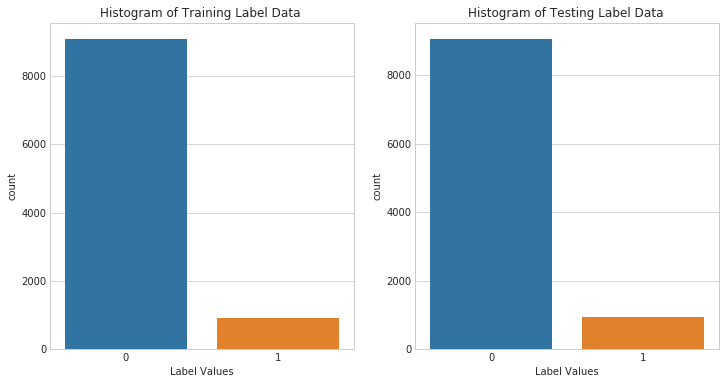

In [27]:
with plt.style.context('seaborn-whitegrid'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=False, figsize=(12,6))
    sns.countplot(train10k_labels['Y'], ax=ax1)
    sns.countplot(test10k_labels['Y'], ax=ax2)
    ax1.set_title('Histogram of Training Label Data ')
    ax2.set_title('Histogram of Testing Label Data ')
    ax1.set_xlabel('Label Values')
    ax2.set_xlabel('Label Values')

Looking at the distributions of labels, we see a fairly extreme imbalance in both the testing and training data. I'll build two classifiers to test whether it harms the classifier performance.

array([5211,    0, 2438,    0,    0, 2402, 4313, 7073, 3024, 5431,    0,
          0, 7704,    0, 5211,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,  504,  504,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

array([5, 0, 5, ..., 3, 4, 9], dtype=int64)

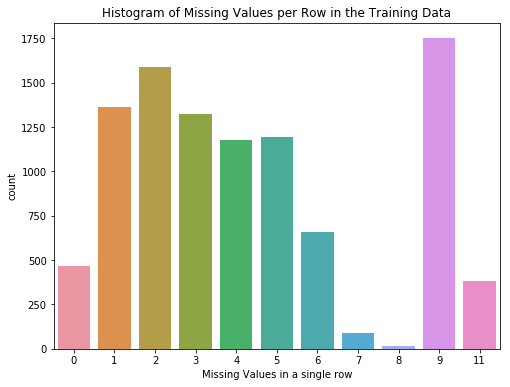

In [28]:
# Counts of missing values per column
train_NA_by_col = np.array(train10k_raw.isnull().sum(axis=0))
display(train_NA_by_col)

# Counts of missing values per row
train_NA_by_row = np.array(train10k_raw.isnull().sum(axis=1))
display(train_NA_by_row)

plt.figure(figsize=(8,6))
ax = sns.countplot(train_NA_by_row)
ax.set_title('Histogram of Missing Values per Row in the Training Data')
ax.set_xlabel('Missing Values in a single row')

array([5237,    0, 2378,    0,    0, 2288, 4212, 7102, 2906, 5413,    0,
          0, 7630,    0, 5237,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,  528,  528,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

array([3, 2, 5, ..., 9, 1, 0], dtype=int64)

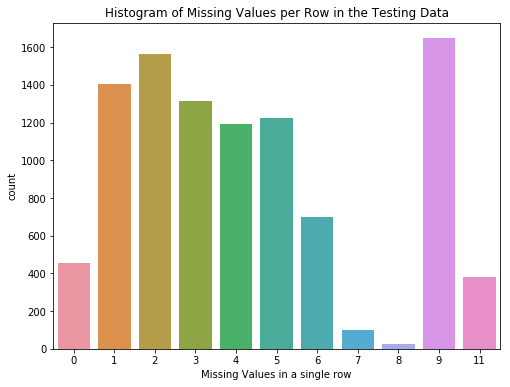

In [29]:
# Counts of missing values per column
test_NA_by_col = np.array(test10k_raw.isnull().sum(axis=0))
display(test_NA_by_col)

# Counts of missing values per row
test_NA_by_row = np.array(test10k_raw.isnull().sum(axis=1))
display(test_NA_by_row)

plt.figure(figsize=(8,6))
ax = sns.countplot(test_NA_by_row)
ax.set_title('Histogram of Missing Values per Row in the Testing Data')
ax.set_xlabel('Missing Values in a single row')

A small number of columns have many missing values (specifically 11 columns out of 334, or $3.3\%$). I don't know anything about how the data was collected or whether the missing values are missing because of systemic issues or whether they're missing completely at random. Still, as less than $3.5\%$ of the columns contain missing values (and some of those columns are missing as much as $77\%$! of their values), they are within standard rules of thumb for deletion (as stated in one of my CSC 424 texts: "Multivariate Data Analysis",m 7th ed. by Hair, Black, Babin, and Anderson). From inspection, we see the same columns in the training and testing data have missing values, so it's very easy to maintain the same columns in both the testing and training. Otherwise, I'd have to drop columns without missing values because of missing values in the complementary data.

In [30]:
test_cols_over_NA_thresh = train10k_raw.columns[test_NA_by_col >= 1]
test10k_trim = test10k_raw.drop(test_cols_over_NA_thresh, axis=1)
train10k_trim = train10k_raw.drop(test_cols_over_NA_thresh, axis=1)
print('\nTraining Data DataFrame after dropping the Columns that had ' + 
      ' missing values in the Testing Data')
display(train10k_trim.head(5))
print('\nTesting Data DataFrame after dropping the Columns that had ' + 
      ' missing values in the Testing Data')
display(test10k_trim.head(5))

train_cols_over_NA_thresh = train10k_raw.columns[train_NA_by_col >= 1]
# test10k_trim = test10k_trim.drop(train_cols_over_NA_thresh, axis=1)
# train10k_trim = train10k_trim.drop(train_cols_over_NA_thresh, axis=1)

print('\nTraining Data DataFrame after dropping the Columns that had ' + 
      ' missing values in the Testing Data')
# display(train10k_trim.head(5))
print('\nTesting Data DataFrame after dropping the Columns that had ' + 
      ' missing values in the Testing Data')
# display(test10k_trim.head(5))
display(train_cols_over_NA_thresh)
display(test_cols_over_NA_thresh)


Training Data DataFrame after dropping the Columns that had  missing values in the Testing Data


,x1,x3,x4,x10,x11,x13,x15,x16,x17,x18,...,x324,x325,x326,x327,x328,x329,x330,x331,x332,x333
0,46,46,196000.0,45,1,48,40,476,508,375,...,59,19,99,21,6,8,11,27,254,110
1,50,50,196000.0,35,4,46,170,504,533,421,...,51,24,89,13,11,2,10,30,169,144
2,50,50,196000.0,63,2,40,170,486,512,399,...,61,20,98,17,7,2,10,24,337,105
3,58,58,195000.0,80,2,36,170,470,505,390,...,50,19,83,12,8,4,4,31,280,165
4,64,64,196000.0,31,2,5,20,490,525,381,...,57,23,99,22,4,8,44,27,143,12



Testing Data DataFrame after dropping the Columns that had  missing values in the Testing Data


,x1,x3,x4,x10,x11,x13,x15,x16,x17,x18,...,x324,x325,x326,x327,x328,x329,x330,x331,x332,x333
0,36,36,197200.0,83,1,22,200,450,472,341,...,63,9,97,24,3,4,7,14,347,111
1,36,38,196010.0,60,3,21,220,416,441,314,...,53,7,81,19,2,3,3,5,265,206
2,46,46,196010.0,86,2,21,170,447,466,341,...,56,10,89,22,4,3,12,13,418,143
3,42,42,196710.0,99,1,57,170,433,450,400,...,63,13,84,6,4,11,2,26,568,275
4,28,28,198010.0,102,1,41,170,462,491,360,...,53,12,88,18,4,5,21,19,328,227



Training Data DataFrame after dropping the Columns that had  missing values in the Testing Data

Testing Data DataFrame after dropping the Columns that had  missing values in the Testing Data


Index(['x0', 'x2', 'x5', 'x6', 'x7', 'x8', 'x9', 'x12', 'x14', 'x27', 'x28'], dtype='object')

Index(['x0', 'x2', 'x5', 'x6', 'x7', 'x8', 'x9', 'x12', 'x14', 'x27', 'x28'], dtype='object')

In [33]:
parameters = {
    'criterion': ['entropy','gini'],
    'max_depth': [1,3],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [2,3,4],
    'random_state': [123]
}

dt_clf = tree.DecisionTreeClassifier()

dt_clf_gs = GridSearchCV(dt_clf, parameters, verbose=1, cv=30, n_jobs=-1)

In [41]:
train10k_trim.shape
c, r = train10k_labels.shape
np.array(train10k_labels).reshape(c, ).shape

(10000,)

In [35]:
%time _ = dt_clf_gs.fit(train10k_trim, np.array(train10k_labels).reshape(c, ))

dt_clf_gs.best_params_, dt_clf_gs.best_score_

Fitting 30 folds for each of 36 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  1.6min finished


Wall time: 1min 39s


({'criterion': 'gini',
  'max_depth': 3,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'random_state': 123},
 0.90920000000000001)

In [31]:
trim_dtree_clf = tree.DecisionTreeClassifier(criterion='entropy',
                                        max_depth = 1,
                                        min_samples_leaf = 1,
                                        min_samples_split = 2,
                                        random_state = 123)
trim_dtree_clf.fit(train10k_trim, train10k_labels)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')

In [69]:
trim_dtree_preds = dtree_clf.predict(test10k_trim)
trim_test_acc = accuracy_score(test10k_labels, trim_dtree_preds)
print('Classifier accuracy when trained with the imbalanced, NA-free training data: {:0.4f}'
      .format(trim_test_acc))

Classifier accuracy when trained with the imbalanced, NA-free training data: 0.9061


The decision tree built with this the NA-free, imbalanced training data had an accuracy of $90.61\%$. Not too shabby! We should probably check the confusion matrix though, just to confirm how awesome this model is. Although I am suspicious that the best decision tree classifier has a max depth of 1...

In [60]:
def confusion_mat_plotter(cfn_matrix, class_labels, title):
    print(cfn_matrix)
    sns.heatmap(cfn_matrix.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('True Class')
    plt.ylabel('Predicted Class')
    plt.title('Confusion Matrix ' + title)

[[9061    0]
 [ 939    0]]


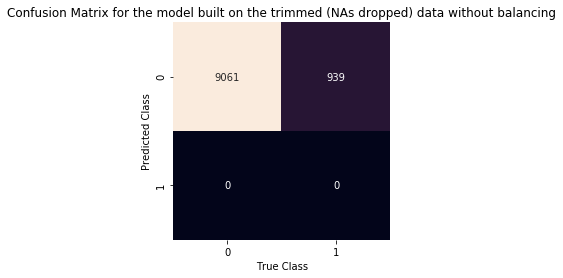

In [71]:
confusion_mat = metrics.confusion_matrix(test10k_labels, trim_dtree_preds)
confusion_mat_plotter(confusion_mat, [0,1], 
                      'for the model built on the trimmed (NAs dropped) data without balancing')

Oh. Our classifier just a simple rule: everything is 0. Because the labels were so lopsided, it simply predicts that everything leads to the dominant label. ACCURACY PARADOX!

                                            Decision Tree Table
| Training Results | Sensitivity/precision | Specificity/Recall |
| :--------------: | --------------------: | :---------------- |
| Raw Data | $\frac{0}{939} = 0$ | $\frac{9061}{10000} = 0.9061$ |
| Raw Data with Balanced Data |  |  |
| Normalize Attributes |  |  |
| Feature Selection |  |  |

In [36]:
# test10k_labels[test10k_labels['Y'] == 1]
# trim_dtree_preds[trim_dtree_preds['Y'] == 1]
# max(trim_dtree_preds)

In [39]:
parameters = {
    'criterion': ['entropy', 'gini'],
    'n_estimators': [30,50,100],
    'max_depth': [1,3,5],
    'max_features': [1,5,15],
    'min_samples_leaf': [1,3,5],
    'min_samples_split': [2,4,6]
}

rf_clf = RandomForestClassifier()

rf_clf_gs = GridSearchCV(rf_clf, parameters, verbose=4, cv=30, n_jobs=-1)

In [42]:
train10k_trim.shape
c, r = train10k_labels.shape
np.array(train10k_labels).reshape(c, ).shape

(10000,)

In [43]:
%time _ = rf_clf_gs.fit(train10k_trim, np.array(train10k_labels).reshape(c, ))

rf_clf_gs.best_params_, rf_clf_gs.best_score_

Fitting 10 folds for each of 486 candidates, totalling 4860 fits


[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:   13.3s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:   26.4s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:   43.8s
[Parallel(n_jobs=4)]: Done 605 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 874 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 1193 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 1560 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 1977 tasks      | elapsed:  4.9min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  7.5min
[Parallel(n_jobs=4)]: Done 2957 tasks      | elapsed:  8.4min
[Parallel(n_jobs=4)]: Done 3520 tasks      | elapsed:  9.6min
[Parallel(n_jobs=4)]: Done 4133 tasks      | elapsed: 11.5min
[Parallel(n_jobs=4)]: Done 4794 tasks      | elapsed: 13.9min
[Parallel(n_jobs=4)]: Done 4860 out of 4860 | elapsed: 14.2min finished


Wall time: 14min 14s


({'criterion': 'gini',
  'max_depth': 5,
  'max_features': 15,
  'min_samples_leaf': 1,
  'min_samples_split': 6,
  'n_estimators': 50},
 0.90920000000000001)

In [82]:
trim_rf_clf = RandomForestClassifier(criterion='gini', max_depth=5, 
                                      max_features=15, min_samples_leaf=1,
                                      min_samples_split=6, n_estimators=50)
trim_rf_clf = train_rf_clf.fit(train10k_trim, train10k_labels)
trim_rf_cv = cross_val_score(trim_rf_clf, train10k_trim,
                             np.array(train10k_labels).reshape(c, ),
                             cv=30,n_jobs=-1, verbose=1)

C:\Users\mattt\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   13.8s finished


Total Classification Accuracy: 0.909 +/- 0.0015)
[[9060    1]
 [ 939    0]]


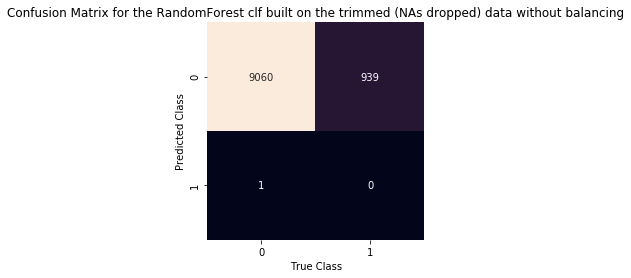

In [62]:
print("Total Classification Accuracy: {:0.3f} +/- {:0.4f})"
      .format(trim_rf_cv.mean(), trim_rf_cv.std()))
trim_rf_preds = trim_rf_clf.predict(test10k_trim)
confusion_mat = metrics.confusion_matrix(test10k_labels, trim_rf_preds)
confusion_mat_plotter(confusion_mat, [0,1], 
                      'for the RandomForest clf built on the trimmed'
                      +' (NAs dropped) data without balancing')

The Random Forest classifier that I spent so much time getting hyperparameters for produces the same accuracy, but it does predict at least (well, exactly) 1 positive label.

                                        Random Forest Table
| Training Results | Sensitivity/precision | Specificity/Recall |
| :--------------: | --------------------: | :---------------- |
| Raw Data | $\frac{0}{939+1} = 0$ | $\frac{9061}{10000} = 0.9061$ |
| Raw Data with Balanced Data |  |  |
| Normalize Attributes |  |  |
| Feature Selection |  |  |

In [66]:
# from imblearn.over_sampling import SMOTE, ADASYN
sm = SMOTE(kind='regular')
train10k_smote, train10k_labels_smote = sm.fit_sample(
                                train10k_trim, np.array(train10k_labels).reshape(c, ))
test10k_smote, test10k_labels_smote = sm.fit_sample(
                                test10k_trim, np.array(test10k_labels).reshape(c, ))

In [79]:
parameters = {
    'criterion': ['entropy','gini'],
    'max_depth': [15,25,35],
    'min_samples_leaf': [1,4,6],
    'min_samples_split': [2,4],
    'random_state': [123]
}

dt_clf = tree.DecisionTreeClassifier()

dt_clf_gs = GridSearchCV(dt_clf, parameters, verbose=1, cv=5, n_jobs=-1)

In [80]:
train10k_smote.shape
c_sm = train10k_labels_smote.shape

%time _ = dt_clf_gs.fit(train10k_smote, np.array(train10k_labels_smote).reshape(c_sm, ))

dt_clf_gs.best_params_, dt_clf_gs.best_score_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.1min finished


Wall time: 2min 11s


({'criterion': 'gini',
  'max_depth': 25,
  'min_samples_leaf': 4,
  'min_samples_split': 2,
  'random_state': 123},
 0.88626113738862611)

In [84]:
dtree_smote = tree.DecisionTreeClassifier(criterion='gini', max_depth=25,
                                          min_samples_leaf=4, min_samples_split=2,
                                          random_state=123)
dtree_smote = dtree_smote.fit(train10k_smote, train10k_labels_smote)
dtree_smote_cv = cross_val_score(dtree_smote, train10k_smote,
                                 train10k_labels_smote,
                                 cv=30,n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   24.5s finished


Total Classification Accuracy: 0.895 +/- 0.1033)
[[8154  907]
 [1906 7155]]


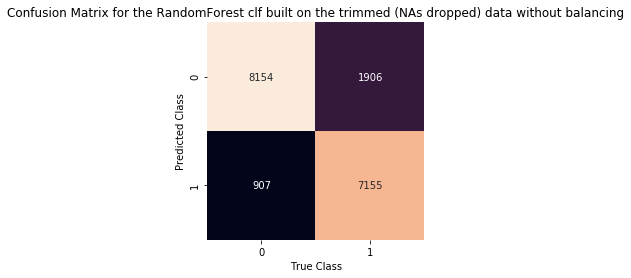

In [86]:
print("Total Classification Accuracy: {:0.3f} +/- {:0.4f})"
      .format(dtree_smote_cv.mean(), dtree_smote_cv.std()))
dtree_smote_preds = dtree_smote.predict(test10k_smote)
confusion_mat = metrics.confusion_matrix(test10k_labels_smote, dtree_smote_preds)
confusion_mat_plotter(confusion_mat, [0,1], 
                      'for the RandomForest clf built on the trimmed'
                      +' (NAs dropped) data without balancing')

This decision tree classifier built on the balanced (via SMOTE) training and testing data isn't quite as accurate as the earlier classifier that predicted everything had the same label, but this classifier has 

                                            Decision Tree Table
|--- Training Results ---|--- Sensitivity/precision ---|---- Specificity/Recall ---|
| :--------------: | --------------------: | :---------------- |
| Raw Data | $\frac{0}{939} = 0$ | $\frac{9061}{10000} = 0.9061$ |
| Raw Data with Balanced Data | $\frac{7155}{7155+1906} = 0.7897$ | $\frac{8154}{8154+907} = 0.8999$ |
| Normalize Attributes |  |  |
| Feature Selection |  |  |

In [88]:
7155/(7155+1906)

0.789647941728286

In [64]:
# help(sns.countplot)
# help(pd.read_csv)
# help(pd.DataFrame.drop)
help(SMOTE.fit_sample)

Help on function fit_sample in module imblearn.base:

fit_sample(self, X, y)
    Fit the statistics and resample the data directly.
    
    Parameters
    ----------
    X : {array-like, sparse matrix}, shape (n_samples, n_features)
        Matrix containing the data which have to be sampled.
    
    y : array-like, shape (n_samples,)
        Corresponding label for each sample in X.
    
    Returns
    -------
    X_resampled : {array-like, sparse matrix}, shape (n_samples_new, n_features)
        The array containing the resampled data.
    
    y_resampled : array-like, shape (n_samples_new,)
        The corresponding label of `X_resampled`

